In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# подготавливаем красивую визуализацию
sns.set(rc={'figure.figsize': (10, 6)})
# также можно изсользовать такую:
# plt.figure(figsize=(9, 6))

In [3]:
# подготавливаем датасет с ценами жилищ в Бостоне (его убрали из датасетов sklearn)
boston = pd.read_csv('E:\GitHub репозитории\Data-Science-course-by-miracl6\CSV\\boston.csv')
boston.rename(columns={'MEDV': 'target'}, inplace=True)
boston.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7


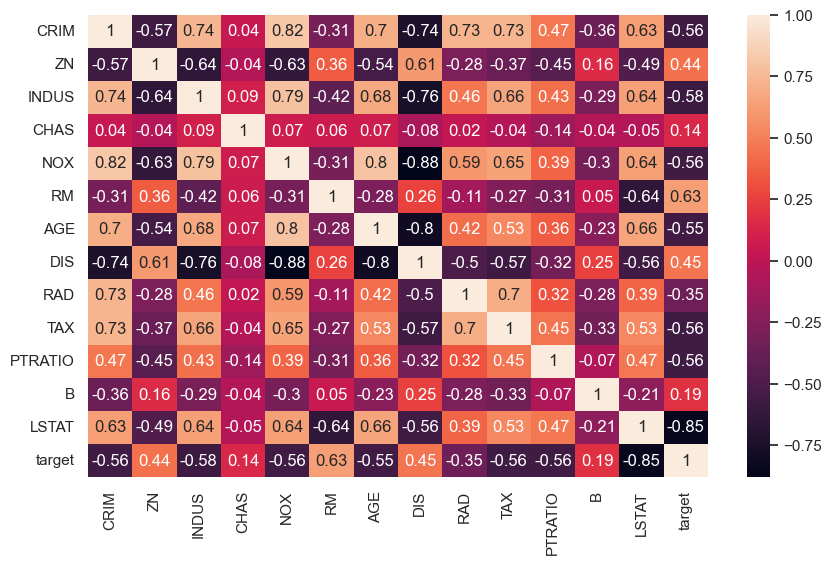

In [4]:
# посмотрим на корреляцию между признаками и целевой переменной
sns.heatmap(boston.corr(method='spearman').round(2), annot=True);

# [seaborn.heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html)

# [pandas.DataFrame.corr](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html)

Может нормировать при решении задачи классификации, а стандартизировать при задаче регрессии?

**Стандартизация/нормализация проводится после разделения на треин и тест, чтобы никакая информация из тестовых данных не попала в тренировочные.**

**У меня на практике не было существенной разницы, что использовать Minmax или standart. Можно попробовать сначала одно, потом другое, сравнить значение метрики.**

**Применяется не всегда. В зависимости от модели. Есть модели, которые этого не требуют. Например, случай лес.**

Если зависимость между признаками линейная, тогда корреляция более 0.7 уже заставляет удалять один из признаков

## Нормирование

Нормализацию используем, когда имеется много выбросов или следует убрать знаки.
Также когда **распределение значений ненормальное**.

Банковский WOE - аналог нормализации.

In [5]:
X = boston.iloc[:, :-1]
y = boston.target

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)  # np.array
X_test_std = sc.transform(X_test)  # np.array

In [7]:
# обучим линейную регрессию
from sklearn.linear_model import LinearRegression

# создадим экземпляр класса линейной регрессии
reg = LinearRegression()
# fit - метод для обучения модели на train данных
reg.fit(X=X_train_std, y=y_train)

LinearRegression()

In [8]:
# процент дисперсии y, объясненный экзагенными переменными
reg.score(X=X_train_std, y=y_train)

0.7508856358979673

Посмотрим, как признаки влияют на целевую переменную. Для этого посмотрим на значение каждого из весов при помощи атрибута coef_, а также попробуем раскрасить ячейки для наглядности

In [9]:
import jinja2

def color_cell(data):
    '''
    Получение цвета ячейки в зависимости от значения
    '''
    if data < -2:
        return 'background-color: skyblue'
    elif data > 2:
        return 'background-color: darksalmon'
    return 'background-color: white'


df_coef = pd.DataFrame(data=np.array([reg.coef_]), columns=X.columns)
df_coef.style.applymap(lambda x: color_cell(x))

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-1.002135,0.696269,0.278065,0.718738,-2.022319,3.145240,-0.176048,-3.081908,2.251407,-1.767014,-2.037752,1.129568,-3.611658


# [pandas.io.formats.style.Styler.applymap](https://pandas.pydata.org/docs/reference/api/pandas.io.formats.style.Styler.applymap.html)

Начнем с первой и довольно популярной метрики MSE (Mean squared error, средняя квадратичная ошибка).  Она применима, если распределение целевой переменной 
y нормальное. либо близко к нормальному. 

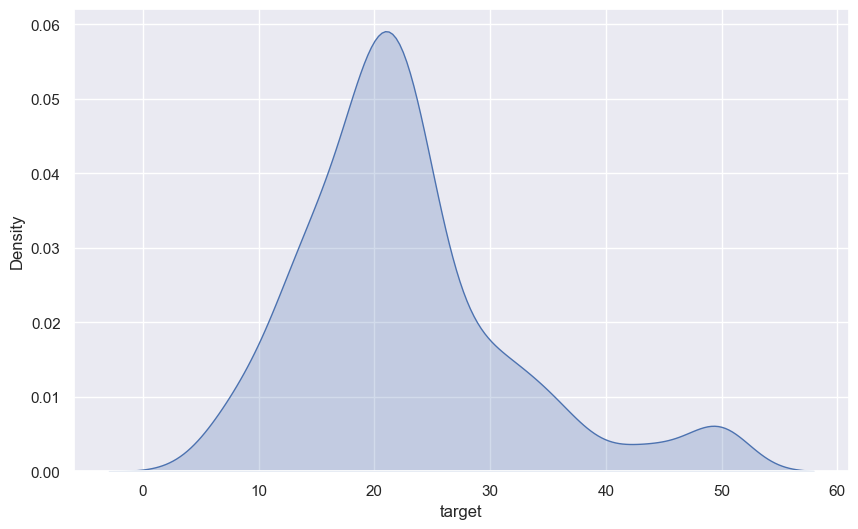

In [10]:
sns.kdeplot(data=y, fill=True);

# [seaborn.kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html#seaborn.kdeplot)

In [11]:
# рассчитаем метрику MSE (средний квадрат ошибок)
from sklearn.metrics import mean_squared_error

# предсказания (ответ) модели
y_pred = reg.predict(X_test_std)
y_pred_train = reg.predict(X_train_std)

In [12]:
print(f'MSE Train: {mean_squared_error(y_train, y_pred_train)}')
print(f'MSE Test: {mean_squared_error(y_test, y_pred)}')

MSE Train: 21.641412753226312
MSE Test: 24.291119474973517


Обязательно всегда необходимо оценивать метрики как на train, так и на test, чтобы избежать той ситуации, когда наш алгоритм либо сильно подогнал ответы под train выборку, либо наоборот, ему не хватило "сил", чтобы качественно обучиться.

Если разница между метриками для данного вида алгоритма не превышает 10-15% (эмпирическое значение), а также ошибка не высока (с учетом бизнес-показателей), то с моделью все хорошо.

# [sklearn.metrics.mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)

In [13]:
# найдем метрику RMSE:
import numpy as np

print(f'RMSE Train: {np.sqrt(mean_squared_error(y_train, y_pred_train))}')
print(f'RMSE Test: {np.sqrt(mean_squared_error(y_test, y_pred))}')

RMSE Train: 4.6520331848801675
RMSE Test: 4.928602182665336


MAE (Mean absolute error, средняя абсолютная ошибка) довольно похожа на метрику MSE. Не зависит от распределения целевой переменной 
y.

In [14]:
from sklearn.metrics import mean_absolute_error

print(f'MAE Train: {mean_absolute_error(y_train, y_pred_train)}')
print(f'MAE Test: {mean_absolute_error(y_test, y_pred)}')

MAE Train: 3.31477162678323
MAE Test: 3.1890919658878483


Так как наше распределение было ненормальное, то больше ориентироваться с этом случае стоит на MAE.

# [sklearn.metrics.mean_absolute_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error)

R2 – Коэффициент детерминации, обозначает долю дисперсии зависимой переменной (долю разнообразных ответов), объясняемой рассматриваемой моделью. Точнее это единица минус доля необъяснимой дисперсии (дисперсии случайной ошибки модели, или условной по признакам дисперсии зависимой переменной) в дисперсии зависимой переменной.

In [15]:
from sklearn.metrics import r2_score

print(f'R2 Train: {r2_score(y_train, y_pred_train)}')
print(f'R2 Test: {r2_score(y_test, y_pred)}')

R2 Train: 0.7508856358979673
R2 Test: 0.668759493535632


# [sklearn.metrics.r2_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)

In [16]:
# функция для нахождения коэффициента детерминации для множественной линейной регрессии
def r2_adjusted(y_true: pd.Series, y_pred: pd.Series,
                X: pd.DataFrame) -> float:
    """
    Коэффициент детерминации для множественной регрессии
    """
    n = len(y_true)
    h = X.shape[1]
    r2 = r2_score(y_true, y_pred)
    
    return 1 - (1 - r2) * (n - 1) / (n - h - 1)

In [17]:
print(f'R2-mult Train {r2_adjusted(y_train, y_pred_train, X_train_std)}')
print(f'R2-mult Test {r2_adjusted(y_test, y_pred, X_test_std)}')

R2-mult Train 0.7425818237612329
R2-mult Test 0.6198262368988503


# Задача 1

1. Бинаризуйте данные при помощи One-Hot, используйте pd.get_dummies(), не забывайте про параметр drop_first=True
2. В качестве матрицы объект-признаки X выберите все столбцы кроме 'Weight'
3. В качестве целевой переменной y выберите столбец 'Weight'
4. Разбейте данные на тренировочные и тестовые, установив обязательно test_size=0.2 и random_state=10 в методе train_test_split()
5. Обучите StandardScaler на тренировочных данных и стандартизируйте тренировочные данные, после чего на обученном стандартизаторе тестовые, как мы делали ранее в предыдущих шагах
6. Обучите модель линейной регрессии. Никакие параметры внутри модели указывать не нужно!
7. Получите предсказания на тестовых данных
8. Рассчитайте метрики MSE, RMSE, MAE для тестовых данных и округлите значений метрик до целых чисел
9. В качестве ответа через пробел введите получившиеся значения метрик MSE, RMSE и MAE соответственно

In [32]:
# импортируем необходимые библиотеки
import pandas as pd
import seaborn as sns

In [33]:
fish = pd.read_csv('E:\GitHub репозитории\Data-Science-course-by-miracl6\CSV\\fish.csv')
fish.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [34]:
# 1 - бинаризируем данные
fish = pd.get_dummies(data=fish, drop_first=True)
fish.head()

,Weight,Length1,Length2,Length3,Height,Width,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
0,242.0,23.2,25.4,30.0,11.5200,4.0200,0,0,0,0,0,0
1,290.0,24.0,26.3,31.2,12.4800,4.3056,0,0,0,0,0,0
2,340.0,23.9,26.5,31.1,12.3778,4.6961,0,0,0,0,0,0
3,363.0,26.3,29.0,33.5,12.7300,4.4555,0,0,0,0,0,0
4,430.0,26.5,29.0,34.0,12.4440,5.1340,0,0,0,0,0,0


In [35]:
# 2 - создаём X
X = fish.iloc[:, 1:]
X.head()

,Length1,Length2,Length3,Height,Width,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
0,23.2,25.4,30.0,11.5200,4.0200,0,0,0,0,0,0
1,24.0,26.3,31.2,12.4800,4.3056,0,0,0,0,0,0
2,23.9,26.5,31.1,12.3778,4.6961,0,0,0,0,0,0
3,26.3,29.0,33.5,12.7300,4.4555,0,0,0,0,0,0
4,26.5,29.0,34.0,12.4440,5.1340,0,0,0,0,0,0


In [36]:
# 3 - создаём таргет
y = fish['Weight']
y[:5]

0    242.0
1    290.0
2    340.0
3    363.0
4    430.0
Name: Weight, dtype: float64

In [37]:
# 4 - разобъём данные на тренировочные и тестовые
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=10)

### Стандартизация/нормализация проводится после разделения на треин и тест, чтобы никакая информация из тестовых данных не попала в тренировочные. 

In [38]:
# 5 - обучим модель и стандартизируем данные
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)  # np.array
X_test_std = sc.transform(X_train)

In [39]:
# 6 - обучим модель линейной регрессии
from sklearn.linear_model import LinearRegression

# создадим экземпляр класса линейной регрессии
reg = LinearRegression()
# fit - метод для обучения модели на train данных
reg.fit(X=X_train_std, y=y_train)

LinearRegression()

In [40]:
# 7 - предсказания на тренировочных и тестовых данных
y_pred_train = reg.predict(X_train_std)
y_pred_test = reg.predict(X_test_std)

In [52]:
# 8 - рассчитаем метрики MSE, RMSE, MAE для тестовых данных
# и округлим значения метрик до целых чисел
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

# Далее возникли ошибки, которые не позволили решить задачу до конца(